In [25]:
# installs
# !pip3 install seaborn
import numpy
import json
import pandas as pd
from copy import deepcopy
from functools import wraps
import os
import logging
# from starter_code import experiment
import torch.multiprocessing as mp
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.fx as fx
from torch.fx.experimental.proxy_tensor import make_fx
from torch.distributed._functional_collectives import all_reduce
from torch.nn.parallel import DistributedDataParallel as DDP
from graph_prof import GraphProfiler
from benchmarks import Experiment, model_names, model_batch_sizes
from graph_prof import GraphProfiler
from graph_tracer import compile
import seaborn as sns
from torch._subclasses.fake_tensor import FakeTensorMode
import matplotlib.pyplot as plt

In [2]:
# initiliaze the experiement to use the resnet model
exp = Experiment(model_names[1], model_batch_sizes[model_names[1]])
exp.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
batch = exp.example_inputs
# graph_transformation = GraphProfiler(exp.model)
# compiled_fn = compile(exp.train_step, GraphProfiler)
# compiled_fn(exp.model, exp.optimizer, batch)

In [7]:
exp.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [15]:
exp.example_inputs[0].size()

torch.Size([4, 3, 224, 224])

In [17]:
torch.randn(4, 100).size()

torch.Size([4, 100])

In [8]:
# create the graph profiler for the resenet model
counter = 0
# set the mps_device
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

# get the model
model = exp.model.to(mps_device)

# create the tracer
model_graph = fx.symbolic_trace(model)

# create the profiler
profiler_example = GraphProfiler(module=model_graph)
print(f"type profiler_example: {type(profiler_example)}")
# iterate over some of the nodes
for node in profiler_example.module.graph.nodes:
    print(node.name)
    if counter == 11:
        break
    counter += 1

tensor([1.], device='mps:0')
type profiler_example: <class 'graph_prof.GraphProfiler'>
x
conv1
bn1
relu
maxpool
layer1_0_conv1
layer1_0_bn1
layer1_0_relu
layer1_0_conv2
layer1_0_bn2
layer1_0_relu_1
layer1_0_conv3


In [41]:
batch_fake[0].size()

torch.Size([4, 3, 224, 224])

In [33]:
exp.example_inputs.size()

AttributeError: 'tuple' object has no attribute 'size'

In [37]:
# import json
 
# Opening JSON file
with open('analysis/analysis.json') as json_file:
    data = json.load(json_file)

json_file.close()

data

{'total_runtime_sec': [3.767719030380249],
 'gpu_total_memory': [104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
  104862720,
 

In [38]:

peak_memory_cols = [col for col in data.keys() if 'total' not in col]
# peak_memory_cols.append('gpu_total_memory')
peak_memory_df = pd.DataFrame()
for col in peak_memory_cols:
    peak_memory_df[col] = data[col]

peak_memory_df

,activation_memory,parameter_memory,intermediate_memory,gradient_memory
0,0,37632,0,0
1,0,37888,0,0
2,0,38144,0,0
3,0,54528,0,0
4,0,54784,0,0
...,...,...,...,...
4111,0,4424,102232132,0
4112,0,4424,102232128,0
4113,0,4424,102232128,0
4114,0,424,102228128,0


In [39]:
# melt the data
peak_memory_df = peak_memory_df.reset_index()
peak_memory_df.columns = ['node number', 'activation_memory', 'parameter_memory', 'intermediate_memory', 'gradient_memory']
peak_memory_df_melt = pd.melt(peak_memory_df, id_vars='node number', value_vars=['activation_memory', 'parameter_memory', 'intermediate_memory', 'gradient_memory'])

peak_memory_df_melt

,node number,variable,value
0,0,activation_memory,0
1,1,activation_memory,0
2,2,activation_memory,0
3,3,activation_memory,0
4,4,activation_memory,0
...,...,...,...
16459,4111,gradient_memory,0
16460,4112,gradient_memory,0
16461,4113,gradient_memory,0
16462,4114,gradient_memory,0


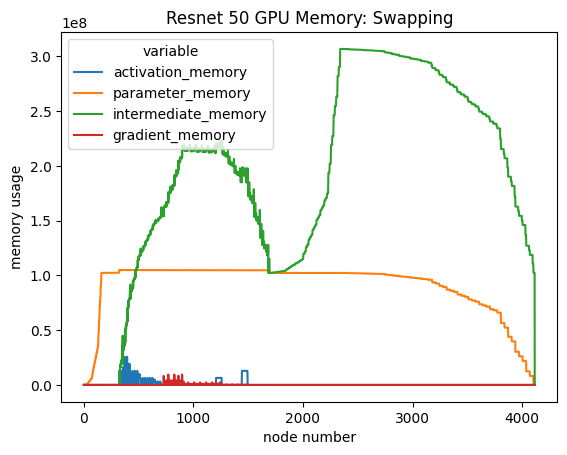

In [40]:
peak_memory_df_melt.columns = ['node number', 'variable', 'memory usage']
sns.lineplot(peak_memory_df_melt, x='node number', y='memory usage', hue='variable').set_title('Resnet 50 GPU Memory: Swapping')
plt.savefig('Resnet50_category_swap.png', bbox_inches='tight')
plt.show()


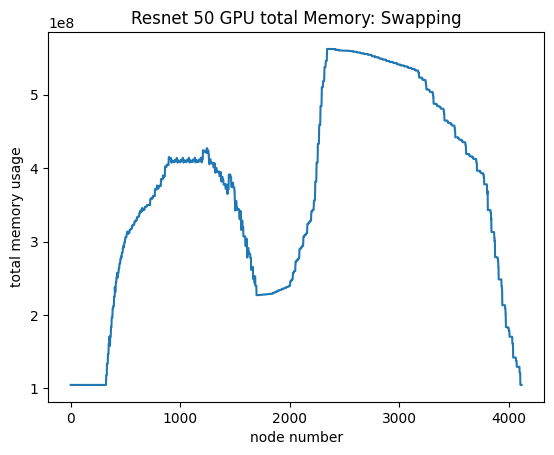

In [41]:
df_gpu_total = pd.DataFrame()
df_gpu_total['total memory usage'] = data['gpu_total_memory']
df_gpu_total['node number'] = [x for x in range(len(data['gpu_total_memory']))]

sns.lineplot(df_gpu_total, x='node number', y='total memory usage').set_title('Resnet 50 GPU total Memory: Swapping')
plt.savefig('Resnet50_total_swap.png', bbox_inches='tight')
plt.show()

In [42]:
# Opening JSON file
with open('analysis/graph_stats.json') as json_file:
    data = json.load(json_file)

json_file.close()

data

{'arg0_1': {'forward_pass': True,
  'category': 'parameter',
  'rank': 0,
  'run_time': [0.0001327991485595703],
  'active_memory': 37632,
  'peak_memory': 37632},
 'arg0_2': {'forward_pass': True,
  'category': 'parameter',
  'rank': 1,
  'run_time': [1.3113021850585938e-05],
  'active_memory': 256,
  'peak_memory': 256},
 'arg0_3': {'forward_pass': True,
  'category': 'parameter',
  'rank': 2,
  'run_time': [5.0067901611328125e-06],
  'active_memory': 256,
  'peak_memory': 256},
 'arg0_4': {'forward_pass': True,
  'category': 'parameter',
  'rank': 3,
  'run_time': [6.198883056640625e-06],
  'active_memory': 16384,
  'peak_memory': 16384},
 'arg0_5': {'forward_pass': True,
  'category': 'parameter',
  'rank': 4,
  'run_time': [1.0251998901367188e-05],
  'active_memory': 256,
  'peak_memory': 256},
 'arg0_6': {'forward_pass': True,
  'category': 'parameter',
  'rank': 5,
  'run_time': [4.291534423828125e-06],
  'active_memory': 256,
  'peak_memory': 256},
 'arg0_7': {'forward_pass': T

In [28]:
df = pd.DataFrame.from_dict(data, orient='index')
df = df.reset_index(names='node')
df.head(5)

,node,forward_pass,category,rank,run_time,active_memory,peak_memory,forward_swap_time,inactive_start_time,backward_swap_time,inactive_end_time,inactive_time
0,arg0_1,True,parameter,0,[0.0001327991485595703],37632.0,37632.0,NaN,NaN,NaN,NaN,NaN
1,arg0_2,True,parameter,1,[1.3113021850585938e-05],256.0,256.0,NaN,NaN,NaN,NaN,NaN
2,arg0_3,True,parameter,2,[5.0067901611328125e-06],256.0,256.0,NaN,NaN,NaN,NaN,NaN
3,arg0_4,True,parameter,3,[6.198883056640625e-06],16384.0,16384.0,NaN,NaN,NaN,NaN,NaN
4,arg0_5,True,parameter,4,[1.0251998901367188e-05],256.0,256.0,NaN,NaN,NaN,NaN,NaN


In [35]:
df[~ df['inactive_time'].isna()]['forward_pass'].unique()

array([ True])

In [32]:
df[df['forward_pass'] == False]

,node,forward_pass,category,rank,run_time,active_memory,peak_memory,forward_swap_time,inactive_start_time,backward_swap_time,inactive_end_time,inactive_time
715,sep,False,intermediate,715,[4.410743713378906e-05],4.0,4.0,NaN,NaN,NaN,NaN,NaN
716,view_1,False,intermediate,716,[3.790855407714844e-05],4.0,4.0,NaN,NaN,NaN,NaN,NaN
717,ones_like,False,intermediate,717,[0.002925872802734375],4.0,4.0,NaN,NaN,NaN,NaN,NaN
718,sep_backward,False,intermediate,718,[3.3855438232421875e-05],4.0,4.0,NaN,NaN,NaN,NaN,NaN
719,div_1,False,intermediate,719,[7.224082946777344e-05],4.0,4.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4111,sqrt_321,False,intermediate,4111,[0.0027718544006347656],4000.0,4000.0,NaN,NaN,NaN,NaN,NaN
4112,div_163,False,intermediate,4112,[0.0029020309448242188],4000.0,4000.0,NaN,NaN,NaN,NaN,NaN
4113,add__390,False,intermediate,4113,[0.0029189586639404297],4000.0,4000.0,NaN,NaN,NaN,NaN,NaN
4114,addcdiv__160,False,intermediate,4114,[0.0038099288940429688],4000.0,4000.0,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='rank', ylabel='inactive_time'>

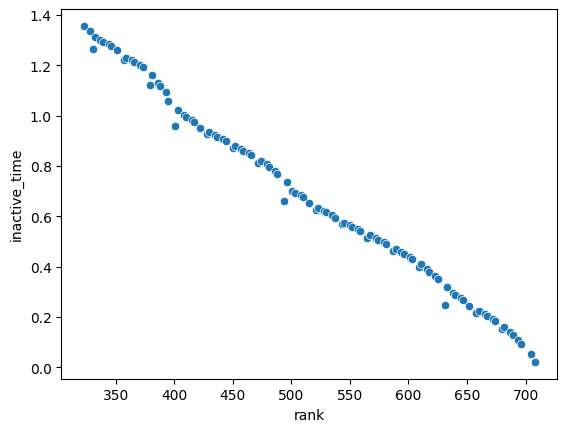

In [36]:
inactive = df[~ df['inactive_time'].isna()]
sns.scatterplot(inactive, x='rank', y='inactive_time')

In [43]:
{data[k]['rank']: k for k in data.keys()}

{0: 'arg0_1',
 1: 'arg0_2',
 2: 'arg0_3',
 3: 'arg0_4',
 4: 'arg0_5',
 5: 'arg0_6',
 6: 'arg0_7',
 7: 'arg0_8',
 8: 'arg0_9',
 9: 'arg0_10',
 10: 'arg0_11',
 11: 'arg0_12',
 12: 'arg0_13',
 13: 'arg0_14',
 14: 'arg0_15',
 15: 'arg0_16',
 16: 'arg0_17',
 17: 'arg0_18',
 18: 'arg0_19',
 19: 'arg0_20',
 20: 'arg0_21',
 21: 'arg0_22',
 22: 'arg0_23',
 23: 'arg0_24',
 24: 'arg0_25',
 25: 'arg0_26',
 26: 'arg0_27',
 27: 'arg0_28',
 28: 'arg0_29',
 29: 'arg0_30',
 30: 'arg0_31',
 31: 'arg0_32',
 32: 'arg0_33',
 33: 'arg0_34',
 34: 'arg0_35',
 35: 'arg0_36',
 36: 'arg0_37',
 37: 'arg0_38',
 38: 'arg0_39',
 39: 'arg0_40',
 40: 'arg0_41',
 41: 'arg0_42',
 42: 'arg0_43',
 43: 'arg0_44',
 44: 'arg0_45',
 45: 'arg0_46',
 46: 'arg0_47',
 47: 'arg0_48',
 48: 'arg0_49',
 49: 'arg0_50',
 50: 'arg0_51',
 51: 'arg0_52',
 52: 'arg0_53',
 53: 'arg0_54',
 54: 'arg0_55',
 55: 'arg0_56',
 56: 'arg0_57',
 57: 'arg0_58',
 58: 'arg0_59',
 59: 'arg0_60',
 60: 'arg0_61',
 61: 'arg0_62',
 62: 'arg0_63',
 63: 'arg0_